In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader 

In [ ]:
# Shoaxing dataset Preprocessing

In [10]:
import os
print(os.getcwd())

c:\Users\JohnKim_PC\Downloads\seminar


In [11]:
folder_dir = './seminar/data/denoise/ECGDataDenoised/' 

In [12]:
data_df = pd.read_csv('./seminar/data/Diagnostics.csv')
data_df.head()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,01-01-1932,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,01-01-1958,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,01-01-1996,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,01-01-1951,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,01-01-1943,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [13]:
data_df['Filepath'] = data_df.FileName.apply(lambda x : os.path.join(folder_dir,x+'.csv'))  #ECG데이터랑 위 진단 데이터랑 합침?
print(type(data_df["Filepath"])) #series

<class 'pandas.core.series.Series'>


In [34]:
# Rhythm을 label로 맵핑
label_map_dict = {rhythm:label for label,rhythm in enumerate(sorted(data_df.Rhythm.unique().tolist()))} #딕셔너리 
label_map_dict

{'AF': 0,
 'AFIB': 1,
 'AT': 2,
 'AVNRT': 3,
 'AVRT': 4,
 'SA': 5,
 'SAAWR': 6,
 'SB': 7,
 'SR': 8,
 'ST': 9,
 'SVT': 10}

In [35]:
data_df['label'] = data_df.Rhythm.apply(lambda x : label_map_dict[x])

## data example

5000
5000


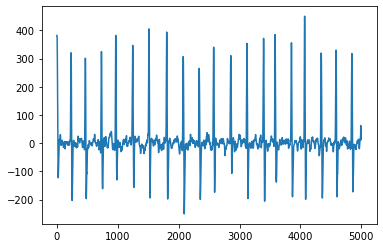

In [21]:
LeadII = pd.read_csv(data_df.Filepath.tolist()[0],header=None)[1].values #[1]값이 LeadII 값
print(len(LeadII))
print(LeadII.shape[0])
plt.plot(LeadII)

In [24]:
b = torch.from_numpy(LeadII)
print(b[:2])

tensor([381.9400, 381.9200], dtype=torch.float64)


# Dataset
- biosignal dataset을 정의하고 만들기
- 요구사항
    - __getitem__ : 본 함수에서  filepath을 통해 읽어오도록 만들기
    - 데이터 중에서 lead II만 반환하도록 하기
    - 읽어오는 중에 오류가 있을 때, 이에 대한 적절한 오류처리 함께 고안하기 "Try and Except"
    - 필요에 따라 정규화 Z-normalization을 한 데이터가 반환되도록 고안하기

In [45]:
# good / 정답으로 대체 
class biosignal_dataset(Dataset):
    def __init__(self,data_df,normalize):
        #self.data=data_df 
        #self.znorm=znorm
        #print("init pass")
        self.filepath_list = data_df.Filepath.tolist()
        self.label_list = data_df.label.tolist()
        self.normalize= normalize

        self.exist_item= None # 더미함수 
        self.error_filepath = list() # 잘못 읽은 변수 따로 모아둠 

    def __len__(self):
        return len(self.filepath_list)
        print("len pass")
    def __getitem__(self,idx):
        try:
           
            filepath = self.filepath_list[idx]
            #label=self.data.label[idx] #self.data.label.tolist()[idx]  여기서도 tolist()를 해줘야 합니다. #tolist()를 하지 않으면 series형식
            label=self.label_list[idx]
            
            leadII= pd.read_csv(filepath, header=None)[1].values # 정수값 반환. 
            #leadII= pd.read_csv(self.data.Filepath.tolist()[idx],header=None)[1].values
            leadII= torch.from_numpy(leadII).float() #nd.array랑 같은 메모리 공유, 텐서로 변환. 
            #leadII= torch.FloatTensor(leadII)

            self.exist_item= idx # this is for alternative idx when going into except clause          
       
       
        except FileNotFoundError :# Always write exact error name  
        #except Exception as e: # 나중에 except에는 구체적인 오류를 명시하는게 좋습니다. except FileNotFoundError : print(e)
            print("error file:", filepath)
        self.error_filepath.append(filepath) #파일에러 난걸 따로 저장.
        filepath=self.filepath_list[self.exist_item] #에러나기 직전의 idx 재활용 
        label= self.label_list[self.exist_item]

        leadII= pd.read_csv(filepath, header=None)[1].values
        leadII=torch.from_numpy(leadII).float()

        if self.normalize:
            leadII= ( leadII- leadII.mean())/( leadII.std()+ 1e-10) # to prevent when std =0 


#   if self.znorm !=None:
#                 print("znorm 출력")
#                 z= (leadII - leadII.mean()) / (torch.std(leadII)+1e-10) # std=0인 상황을 고려하여 아주 작은 값을 넣어줍니다. 
#                 print("znorm 계산식 pass")
#                 leadII = z
        return leadII,label

In [27]:
""" 
series시리즈는 원본과 사본이 같은 메모리를 유지한다. 따라서. tolist()로 리스트 객체로 변환한다. """


' \nseries시리즈는 원본과 사본이 같은 메모리를 유지한다. 따라서. tolist()로 리스트 객체로 변환한다. '

In [ ]:
# 정답 
class biosignal_dataset(Dataset):
    def __init__(self,data_df,normalize):
        self.filepath_list = data_df.Filepath.tolist()
        self.label_list= data_df.label.tolist()
        self.normalize = normalize
        
        self.exist_item = None
        self.error_filepath = list() # we can check error file list later
        
    def __len__(self):
        return len(self.filepath_list)
        
    def __getitem__(self,idx):
        
        try:
            filepath = self.filepath_list[idx]
            label = self.label_list[idx]
        
            LeadII = pd.read_csv(filepath,header=None)[1].values
            LeadII = torch.from_numpy(LeadII).float()
            
            self.exist_item = idx #this is for alternative idx when going into except clause
        
        except FileNotFoundError :  # always write exact error name
            print('error file:',filepath)
            self.error_filepath.append(filepath)
            
            filepath = self.filepath_list[self.exist_item]
            label = self.label_list[self.exist_item]
        
            LeadII = pd.read_csv(filepath,header=None)[1].values
            LeadII = torch.from_numpy(LeadII).float()
            
        
        if self.normalize:
            LeadII = (LeadII - LeadII.mean())/(LeadII.std()+ 1e-10) # to prevent when std=0
            
        
        return LeadII,label

# Data 확인

In [47]:
#z-normalization 확인 
tmp_dataset = biosignal_dataset(data_df, normalize=True)


In [53]:
data,label=tmp_dataset[0]
print(data, data.shape)
print(label)

tensor([4.8013, 4.8011, 4.7845,  ..., 0.0657, 0.1607, 0.2937]) torch.Size([5000])
1


In [56]:
data_numpy = data.view(-1).numpy()
print(data_numpy.shape)
print(data_numpy)

(5000,)
[4.801309   4.801052   4.7844605  ... 0.06565921 0.16071844 0.29366758]


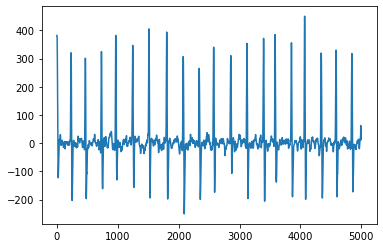

In [ ]:
plt.plot(data_numpy)
plt.show()